In [1]:
import tflearn 
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
import numpy as np
from skimage.util import view_as_windows as vaw
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
with tf.Session() as sess:
    print (sess.run(c))
import os, sys
import glob
from progressbar import ProgressBar
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.layers.recurrent import lstm
from tflearn.layers.core import fully_connected

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


[[22. 28.]
 [49. 64.]]


In [6]:
# uniprot_keyword = 'keyword1+keyword2+keyword3' # if you want to do multiple search terms
uniprot_keyword = 'antibody+DNA-binding' # what to query uniprot for
string_len = 15 # how many amino acids to take for each substring
uniprot_limit = 1000 # how many proteins to get for each class from uniprot
# how many amino acids to skip during cutting when moving to next cut.
# if this number is 1, it just moves to the next one.
stride = 1

In [20]:
def get_uniprot_data(kw, numxs):
    '''Goes to the uniprot website and searches for 
       data with the keyword given. Returns the data 
       found up to limit elements.'''

    kws = ['NOT+' + kw, kw] # how to make not keyword: kws = ['NOT+' + kw, kw]
    Protein_data = {}
    
    for i in range(2):
        kw = kws[i]
        url1 = 'http://www.uniprot.org/uniprot/?query='
        url2 = '&columns=sequence&format=tab&limit='+str(numxs)
        query_complete = url1 + kw + url2
        request = Request(query_complete)
        response = urlopen(request)
        data = response.read()
        data = str(data, 'utf-8')
        data = data.split('\n')
        data = data[1:-1]
        Protein_data[str(i)] = list(map(lambda x:x.lower(),data))
       
    # add the negative set of proteins to the positive set
    x = Protein_data['0'] + Protein_data['1']
    
    # create labels for all proteins --- initially zero
    y = np.zeros([len(x), ])
    y[1000:] = 1. 
    
    return x, y

In [21]:
def cut_strings(seqs, labels, length, padlen=None):
    '''Cut up the amino acid strings into the specified length.'''
    
    if padlen is None:
        padlen = int(0.95 * length)

    x = np.zeros([0, length, 1])
    y = np.zeros([0, ])
    count = 0
    xlen = None
    bar = ProgressBar()

    for seq in bar(seqs):
        seq_nums = []
        for letter in seq:
            seq_nums.append(max(ord(letter)-97, 0))

        if len(seq_nums) > length:
            padded_seq = np.pad(np.asarray(seq_nums), (padlen, padlen),
                                          'constant', constant_values=23.)
            cut_seq = vaw(padded_seq, (length, ))
            y = np.concatenate((y, np.ones([cut_seq.shape[0], ])*labels[count]))
            x = np.concatenate((x, cut_seq[..., None]))
            count += 1
        else:
            continue

    print('Used {} proteins.'.format(count))
    plt.hist(x[x != 22.].flatten(), bins=25)
    plt.show()

    return x, y

In [22]:
# call the get_uniprot_data function to get data and labels
X, Y = get_uniprot_data(uniprot_keyword, uniprot_limit)
print(len(X))

2000


100% (2000 of 2000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26


Used 2000 proteins.


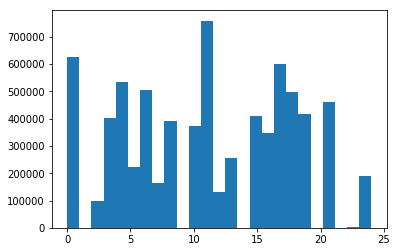

In [23]:
X, Y = cut_strings(X, Y, string_len, stride)

In [24]:
# get the shape of the data...should be number of examples X length of each sequence
print(X.shape)
print(Y.shape)
print(np.unique(X)) # see all of the different numbers in X

(498534, 15, 1)
(498534,)
[ 0.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 15. 16. 17. 18. 19. 21.
 22. 23. 24.]


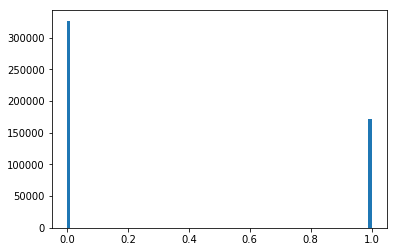

In [25]:
plt.hist(Y, bins=100)
plt.show()

In [26]:
Y = tflearn.data_utils.to_categorical(Y, 2)

In [27]:
 tf.reset_default_graph()

In [28]:
tb_dir = '/home/mpcr/ConsensusSeqPred'
name = str(string_len) + '_seq_len_'
name += str(stride) + '_stride'

In [29]:
# define the model
net_in = tflearn.input_data([None, string_len, 1])
layer1 = lstm(net_in, 10, return_seq=True)
layer2 = lstm(layer1, 10)
out = fully_connected(layer2, 2, activation='softmax')

In [30]:
net = tflearn.regression(out, optimizer='adam', learning_rate=0.0005,
                         loss='categorical_crossentropy')

In [31]:
# start tensorboard 
os.system('tensorboard --logdir=' + tb_dir)

65280

In [ ]:
# Execute training on the model
model = tflearn.DNN(net, tensorboard_verbose=2, tensorboard_dir=tb_dir)
model.fit(X, Y, validation_set=0.25, show_metric=True, n_epoch=9,
          batch_size=200, snapshot_step=200, run_id=name)